In [140]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbn
import pandas as pd
from matplotlib.pyplot import figure
from itertools import cycle, islice
from power_perp import everlasting_power_perp_price, everlasting_power_perp_price_,  power_perp_price


ImportError: cannot import name 'everlasting_power_perp_price_' from 'power_perp' (/Users/josephclark/Documents/GitHub/perpfundingtest/power_perp.py)

In [137]:
def liteGBM(S0, mu, sigma, T, dt=1):
    N = round(T/dt)
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt)
    S =  S0*np.exp((mu-0.5*sigma**2)*t + sigma*W)
    return np.insert(S,0,S0)

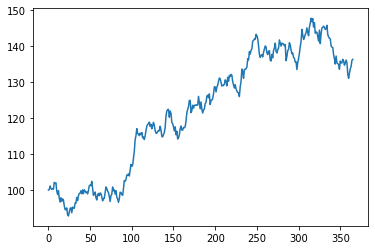

In [138]:
# One sim
S = liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365)
sbn.lineplot(data=S)

In [5]:
# Set up params
spot = 100
vol = 0.8
drift = 0
funding_period = 1/365
power = 2

In [6]:
# Power perp pricing
power_perp_price(spot, funding_period, vol, drift, power)

10017.549628054265

In [7]:
# Everlasting power perp pricing
everlasting_power_perp_price(spot, funding_period, vol, drift, power)

10035.16096228955

In [71]:
# Everlasting power perp pricing
everlasting_power_perp_price2(spot, 1/365, vol, drift, power)

10017.580481144776

In [63]:
# Simulator for total pnl
def simPerp(S0, mu, sigma, numPeriods, fundingPeriod, Minf): # Minf is the pricing function
    # GBM path
    S = liteGBM(S0=S0, mu = mu, sigma=sigma, T = numPeriods* fundingPeriod, dt = fundingPeriod)
    # Funding path (Mark - Index)
    #d = [( Minf(s) + s**2)/2 - s**2  for s in S[1:]] # Dave's proposed variation (Average of mark and index - index)
    d = [ Minf(s) - s**2 for s in S[1:]]
    # Total cash for long power perp (cost - funding + sale) 
    return -Minf(S0) - np.sum(d) + Minf(S[-1])

In [65]:
# Use everlasting pp 
Minf = lambda spot: everlasting_power_perp_price(spot, funding_period, vol, drift, power)
tmp =[simPerp(100, 0, 0.8, 1/funding_period, funding_period, Minf) for _ in range(10000)]
np.mean(tmp)

8296.251327855745

In [66]:
# Use expiring  
Minf = lambda spot: power_perp_price(spot, funding_period, vol, drift, power)
tmp =[simPerp(100, 0, 0.8, 1/funding_period, funding_period, Minf) for _ in range(10000)]
np.mean(tmp)

8941.247553062482

So this means that if we use `everlasting_power_perp_price` in the sims we get a persistent return (~-10k over the year) when we simulate the pnl from holding a position and paying `Mark - Index` on gbm paths. If we use `power_perp_price` the expected return is zero as we would expect. 

Some more checks:
- Mark and index seem reasonable 
- Funding % and $ are as expected
- GBM is behaving properly 

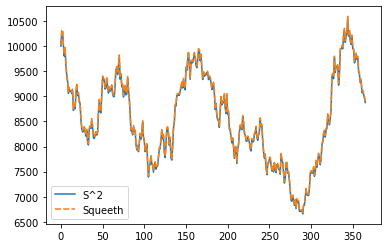

In [197]:
# Look at price vs squeeth
Minf = lambda spot: everlasting_power_perp_price(spot, funding_period, vol, drift, power)
sbn.lineplot(data={'S^2':S**2, 'Squeeth':Minf(S)})

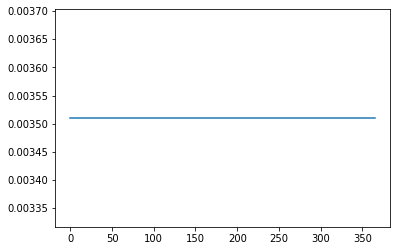

In [198]:
# Funding as %
sbn.lineplot(data=np.log(Minf(S)/S**2))

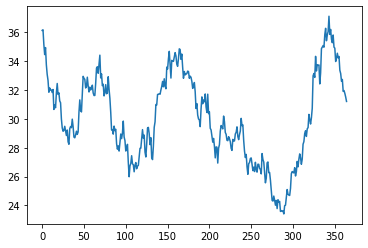

In [199]:
# Fundign in dollars
d = [Minf(s)-s**2 for s in S[1:]]
sbn.lineplot(data=d)

In [200]:
-Minf(S[0]) 

-10035.16096228955

In [201]:
- np.sum(d)  

-10964.454606932919

In [202]:
Minf(S[-1])

8908.549785070842

In [208]:
# Check returns for GBM
np.mean([liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365)[-1] for _ in range(10000)])

99.8970512580244

In [210]:
# Check vol for GBM
np.mean([np.std(np.diff(np.log(liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365))))*np.sqrt(365) for _ in range(10000)])

0.19959587367774398

TypeError: unsupported operand type(s) for +: 'AxesSubplot' and 'AxesSubplot'

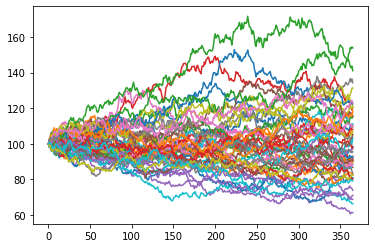

In [213]:
np.mean([sbn.lineplot(data=liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365)) for _ in range(50)])

In [62]:
numSims = 500000
dt = 1/365
S = [liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = dt) for _ in range(numSims)]
qthing = [dt*np.sum(s[1:-1]**2)/(s[-1]**2-s[0]**2) for s in S]
np.mean(qthing)

-0.3209991400119476

In [69]:
(2400/2401)**10000

0.015517313907714325

In [118]:
def everlasting_power_perp_price2(spot, funding_period, vol, drift, power):
    """
    Solving directly: 
    """
    f = 1/funding_period
    k = (power - 1) * (2 * drift + power * vol ** 2) / 2
    a = f/(f+1) * np.exp(k/f)
    return (spot ** power)/f  * (1 / (1 - a) -1) 

In [144]:
everlasting_power_perp_price2(100, 1/(365*24*60), 0.8, 0, 2)

27777.841667186007

In [145]:
np.log(27801.1109829557/10000)/365

0.0028013449049854857

In [146]:
def everlasting_power_perp_price(spot, funding_period, vol, drift, power, time_to_tick=0):
    """
    `time_to_tick` determines the first term in the geometric series.
    The formula located at https://www.paradigm.xyz/2021/08/power-perpetuals/
    assumes that `time_to_tick = funding_period`.
    """
    k = (power - 1) * (2 * drift + power * vol ** 2) / 2
    return (spot ** power) * np.exp(time_to_tick * k) / (2 - np.exp(funding_period * k))

In [150]:
everlasting_power_perp_price(spot, 1/365, 0.8, 0, 2)

10017.580481144776

In [86]:
k = (power - 1) * (2 * drift + power * vol ** 2) / 2

In [90]:
(spot ** power)/f  * ( 1 / (1 - f/(f+1) * np.exp(k/f) ) -1) 

27869.990302643906

In [82]:
k

0.6400000000000001

In [83]:
np.exp(k/f)

1.0017549628054265

In [84]:
f/(f-1)

1.0027472527472527

In [91]:
(power - 1) * (2 * drift + power * vol ** 2) / 2

0.6400000000000001

In [92]:
drift

0

In [93]:
power

2

In [94]:
vol

0.8